In [0]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from pyspark.sql import SparkSession

# create session
spark = SparkSession.builder.appName("Olympics_Project").getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
olympic_hosts_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://olympics-spark-project/olympic_hosts.csv")

In [0]:
olympic_medals_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://olympics-spark-project/olympic_medals.csv")

In [0]:
olympic_results_schema = StructType([
    StructField("discipline_title", StringType(), True),
    StructField("event_title", StringType(), True),
    StructField("slug_game", StringType(), True),
    StructField("participant_type", StringType(), True),
    StructField("medal_type", StringType(), True),
    StructField("athletes", StringType(), True),
    StructField("rank_equal", BooleanType(), True),
    StructField("rank_position", IntegerType(), True),
    StructField("country_name", StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("country_3_letter_code", StringType(), True),
    StructField("athlete_url", StringType(), True),
    StructField("athlete_full_name", StringType(), True),
    StructField("value_unit", DecimalType(), True),
    StructField("value_type", StringType(), True)
])

olympic_results_df = spark.read.schema(olympic_results_schema).format("csv").option("header", "true").load("s3://olympics-spark-project/olympic_results.csv")

In [0]:
# Change column name to match across tables
olympic_medals_df = olympic_medals_df.withColumnRenamed("slug_game", "game_id")
olympic_hosts_df = olympic_hosts_df.withColumnRenamed("game_slug", "game_id")

# Join the tables
medals_and_hosts = olympic_medals_df.join(olympic_hosts_df, on="game_id", how="inner")

# Drop unnecessary Columns
columns_to_drop = ["country_3_letter_code", "event_gender", "athlete_url", "game_start_date", "game_end_date"]
medals_and_hosts = medals_and_hosts.drop(*columns_to_drop )

medals_and_hosts.createOrReplaceTempView("medals_and_hosts")

In [0]:
medals_and_hosts.show(3)

+------------+----------------+-------------+----------+----------------+-----------------+--------------------+------------+------------+-------------+------------+-----------+---------+
|     game_id|discipline_title|  event_title|medal_type|participant_type|participant_title|   athlete_full_name|country_name|country_code|game_location|   game_name|game_season|game_year|
+------------+----------------+-------------+----------+----------------+-----------------+--------------------+------------+------------+-------------+------------+-----------+---------+
|beijing-2022|         Curling|Mixed Doubles|      GOLD|        GameTeam|            Italy|Stefania CONSTANTINI|       Italy|          IT|        China|Beijing 2022|     Winter|     2022|
|beijing-2022|         Curling|Mixed Doubles|      GOLD|        GameTeam|            Italy|        Amos MOSANER|       Italy|          IT|        China|Beijing 2022|     Winter|     2022|
|beijing-2022|         Curling|Mixed Doubles|    SILVER|    

In [0]:
# Total number of medals per country
medal_count = spark.sql('''
    SELECT 
    country_name,
    COUNT(*) AS total_medals,
    SUM(CASE WHEN medal_type = 'GOLD' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN medal_type = 'SILVER' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN medal_type = 'BRONZE' THEN 1 ELSE 0 END) AS Bronze
FROM 
    medals_and_hosts
GROUP BY 
    country_name
ORDER BY 
    total_medals DESC;
                        ''')

medal_count.show(10)


+--------------------+------------+----+------+------+
|        country_name|total_medals|Gold|Silver|Bronze|
+--------------------+------------+----+------+------+
|United States of ...|        3094|1222|  1000|   872|
|        Soviet Union|        1272| 510|   396|   366|
|             Germany|        1167| 385|   399|   383|
|       Great Britain|        1045| 332|   363|   350|
|              France|         952| 282|   305|   365|
|People's Republic...|         807| 333|   260|   214|
|               Italy|         805| 274|   243|   288|
|              Sweden|         709| 219|   241|   249|
|           Australia|         627| 190|   196|   241|
|              Canada|         602| 163|   196|   243|
+--------------------+------------+----+------+------+
only showing top 10 rows



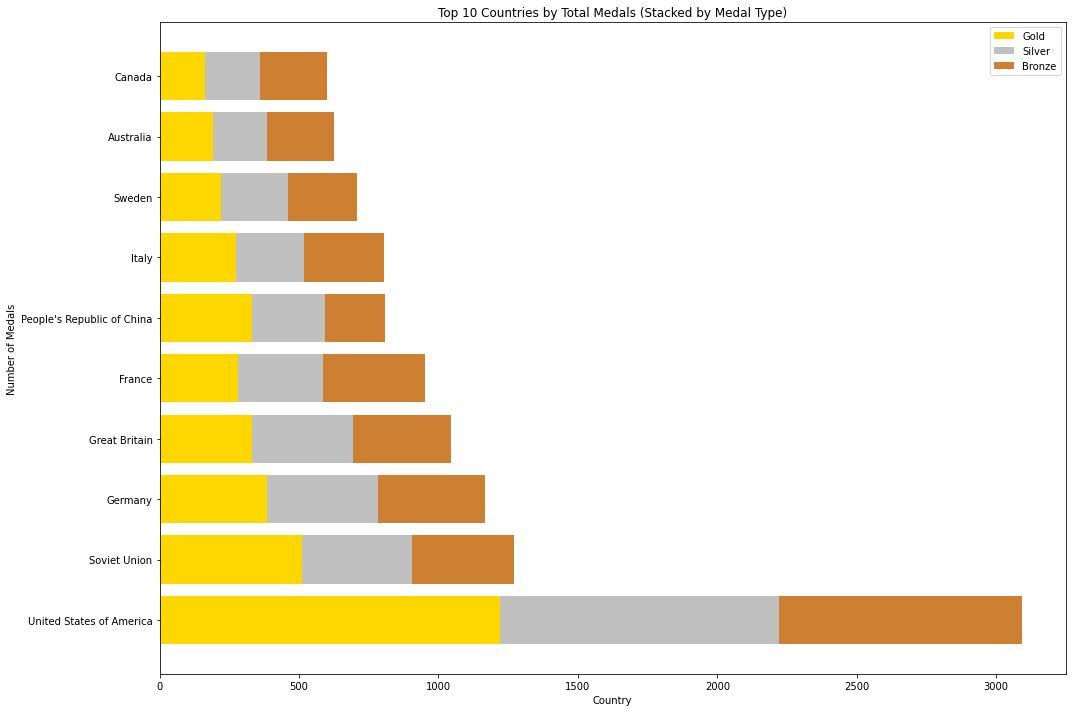

In [0]:

# Visualize data
medal_count_df = medal_count.toPandas()

top_10_df = medal_count_df.head(10)
countries = top_10_df['country_name']
gold = top_10_df['Gold']
silver = top_10_df['Silver']
bronze = top_10_df['Bronze']

fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(countries, gold, label='Gold', color='gold')
ax.barh(countries, silver, left=gold, label='Silver', color='silver')
ax.barh(countries, bronze, left=gold+silver, label='Bronze', color='#CD7F32')

ax.set_xlabel('Country')
ax.set_ylabel('Number of Medals')
ax.set_title('Top 10 Countries by Total Medals (Stacked by Medal Type)')
ax.legend()

# Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [0]:
winter_medal_count = spark.sql('''
  SELECT country_name,
  COUNT(*) AS total_medals,
  SUM(CASE WHEN medal_type = 'GOLD' THEN 1 ELSE 0 END) AS Gold,
  SUM(CASE WHEN medal_type = 'SILVER' THEN 1 ELSE 0 END) AS Silver,
  SUM(CASE WHEN medal_type = 'BRONZE' THEN 1 ELSE 0 END) AS Bronze

  FROM medals_and_hosts
  WHERE game_season == "Winter"
  GROUP BY country_name
  ORDER BY total_medals DESC;
                               ''')

winter_medal_count.show(10)

+--------------------+------------+----+------+------+
|        country_name|total_medals|Gold|Silver|Bronze|
+--------------------+------------+----+------+------+
|              Norway|         413| 152|   135|   126|
|United States of ...|         362| 119|   134|   109|
|             Germany|         327| 132|   115|    80|
|             Austria|         265|  76|    94|    95|
|              Canada|         247|  86|    78|    83|
|        Soviet Union|         217|  89|    65|    63|
|         Switzerland|         184|  68|    53|    63|
|              Sweden|         184|  67|    54|    63|
|             Finland|         180|  46|    68|    66|
|               Italy|         159|  48|    48|    63|
+--------------------+------------+----+------+------+
only showing top 10 rows



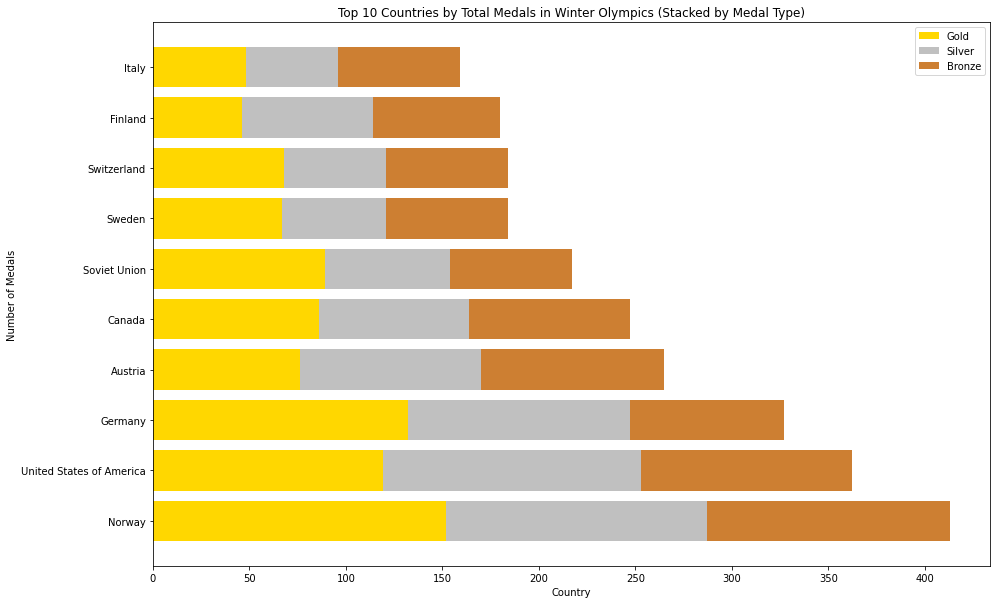

In [0]:
winter_medal_count_df = winter_medal_count.toPandas()
top_10_winter_df = winter_medal_count_df.head(10)
countries = top_10_winter_df['country_name']
gold = top_10_winter_df['Gold']
silver = top_10_winter_df['Silver']
bronze = top_10_winter_df['Bronze']

fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(countries, gold, label='Gold', color='gold')
ax.barh(countries, silver, left=gold, label='Silver', color='silver')
ax.barh(countries, bronze, left=gold+silver, label='Bronze', color='#CD7F32')

ax.set_xlabel('Country')
ax.set_ylabel('Number of Medals')
ax.set_title('Top 10 Countries by Total Medals in Winter Olympics (Stacked by Medal Type)')
ax.legend()

plt.show()

In [0]:
summer_medal_count = spark.sql('''
  SELECT country_name,
  COUNT(*) AS total_medals,
  SUM(CASE WHEN medal_type = 'GOLD' THEN 1 ELSE 0 END) AS Gold,
  SUM(CASE WHEN medal_type = 'SILVER' THEN 1 ELSE 0 END) AS Silver,
  SUM(CASE WHEN medal_type = 'BRONZE' THEN 1 ELSE 0 END) AS Bronze

  FROM medals_and_hosts
  WHERE game_season == "Summer"
  GROUP BY country_name
  ORDER BY total_medals DESC;
                               ''')

winter_medal_count.show(10)

+--------------------+------------+----+------+------+
|        country_name|total_medals|Gold|Silver|Bronze|
+--------------------+------------+----+------+------+
|United States of ...|        2732|1103|   866|   763|
|        Soviet Union|        1055| 421|   331|   303|
|       Great Britain|        1008| 318|   358|   332|
|             Germany|         840| 253|   284|   303|
|              France|         805| 237|   261|   307|
|People's Republic...|         723| 309|   225|   189|
|               Italy|         646| 226|   195|   225|
|           Australia|         608| 184|   189|   235|
|             Hungary|         543| 190|   162|   191|
|              Sweden|         525| 152|   187|   186|
+--------------------+------------+----+------+------+
only showing top 10 rows



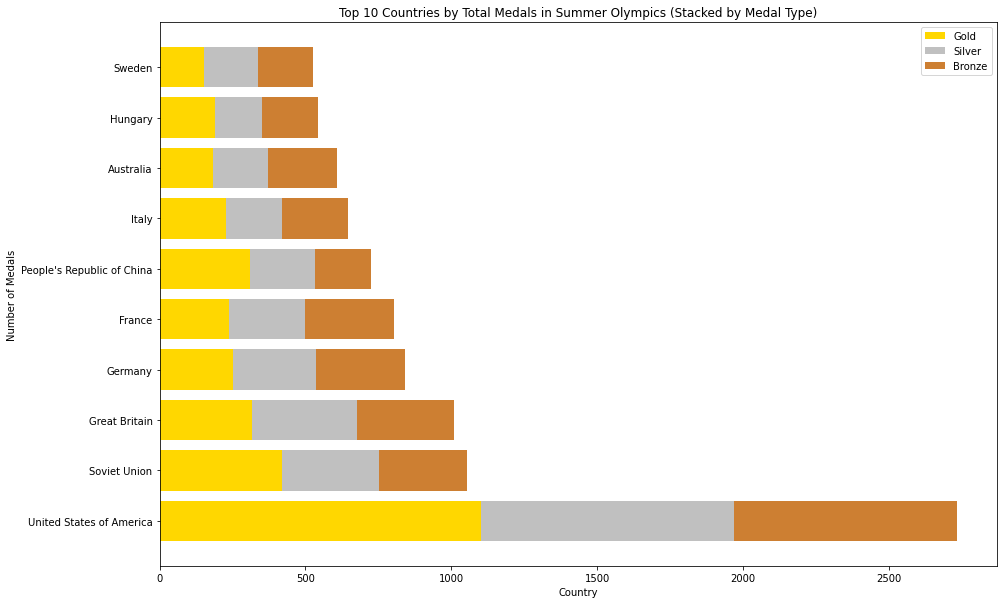

In [0]:
summer_medal_count_df = summer_medal_count.toPandas()
top_10_summer_df = summer_medal_count_df.head(10)
countries = top_10_summer_df['country_name']
gold = top_10_summer_df['Gold']
silver = top_10_summer_df['Silver']
bronze = top_10_summer_df['Bronze']

fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(countries, gold, label='Gold', color='gold')
ax.barh(countries, silver, left=gold, label='Silver', color='silver')
ax.barh(countries, bronze, left=gold+silver, label='Bronze', color='#CD7F32')

ax.set_xlabel('Country')
ax.set_ylabel('Number of Medals')
ax.set_title('Top 10 Countries by Total Medals in Summer Olympics (Stacked by Medal Type)')
ax.legend()

plt.show()

In [0]:
medals_per_country_discipline = spark.sql('''
  SELECT country_name, discipline_title, total_medals
  FROM (
    SELECT country_name, discipline_title, 
      COUNT(medal_type) AS total_medals,
      ROW_NUMBER() OVER(PARTITION BY country_name ORDER BY COUNT(medal_type) DESC) AS rank
    FROM medals_and_hosts
    GROUP BY country_name, discipline_title
) AS ranked_disciplines
WHERE rank = 1
ORDER BY total_medals DESC;
                                          ''')

medals_per_country_discipline.show(10)

+--------------------+--------------------+------------+
|        country_name|    discipline_title|total_medals|
+--------------------+--------------------+------------+
|United States of ...|           Athletics|         824|
|           Australia|            Swimming|         212|
|       Great Britain|           Athletics|         211|
|        Soviet Union|           Athletics|         193|
|              Norway|Cross Country Skiing|         135|
|         Netherlands|       Speed skating|         133|
|               Italy|             Fencing|         130|
|             Austria|       Alpine Skiing|         128|
|              France|             Fencing|         123|
|             Finland|           Athletics|         114|
+--------------------+--------------------+------------+
only showing top 10 rows

